## Importing Libraries

In [1]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
sns.set(color_codes=True)
%matplotlib inline

In [2]:
nlp = spacy.load('en')

Loading training data

In [3]:

with open('../data/training_data.txt','r') as fh:
    data = fh.read().splitlines()

Splitting every line to find sentence and corresponding label

In [4]:
sentence = []
label = []
for sent in data:
    sent = sent.split(',,,')
    sentence.append(sent[0].strip())
    label.append(sent[1].strip())

In [5]:
feature_columns = [
    'FIRST_WORD', 'FIRST_WORD_POS','FIRST_NBOR_POS', 'ROOT_TAG',
]

In [6]:
#category encoding while training and reverse while testing
label_dict = {
    'who': 0,
    'what': 1,
    'when': 2,
    'affirmation': 3,
    'unknown': 4,
    0: 'who',
    1: 'what',
    2: 'when',
    3: 'affirmation',
    4: 'unknown'
}

In [7]:
def process(sentence):
    wh_word_ = ''
    wh_pos_ = ''
    wh_nbor_pos_ = ''
    root_tag_ = ''
    doc = nlp(sentence.lower())
    sent_list = list(doc.sents)
    sent = sent_list[0]
    found = False
    for token in sent:
        if found == False:
            if (token.tag_ in ('MD', 'VBZ', 'VBP')
                    and token.i == 0) or token.tag_ in ('WP', 'WDT', 'WP$',
                                                        'WRB'):
                wh_word_ = token.text
                wh_pos_ = token.tag_
                wh_nbor_pos_ = sent[token.i + 1].tag_
                found = True
            if token.i - 1 >= 0 and token.i + 1 < len(sent):
                if (sent[token.i - 1].dep_ in ('punct')
                        and sent[token.i].tag_ in ('VBZ', 'MD', 'VBP')):
                    wh_word_ = token.text
                    wh_pos_ = token.tag_
                    wh_nbor_pos_ = sent[token.i + 1].tag_
                    found = True
        if token.dep_ == 'ROOT':
            root_tag_ = token.tag_
    if found == False:
        wh_word_ = sent[0].text
        wh_pos_ = sent[0].tag_
        wh_nbor_pos_ = sent[1].tag_
    return wh_word_, wh_pos_, wh_nbor_pos_, root_tag_

In [8]:
##processing training data to find features

data = []
for i in range(len(sentence)):
    data.append(list(process(sentence[i])))
print('Completed')

Completed


In [9]:
training_data = pd.DataFrame(data=data,columns=feature_columns)

In [10]:
training_data['LABEL'] = label

In [11]:
training_data.head()

,FIRST_WORD,FIRST_WORD_POS,FIRST_NBOR_POS,ROOT_TAG,LABEL
0,how,WRB,VBD,VB,unknown
1,what,WP,NNS,VBD,what
2,how,WRB,MD,VB,unknown
3,what,WDT,NN,VBZ,what
4,what,WP,VBZ,VBZ,what


Loading Test Data

In [12]:
with open('../data/test_data.txt','r') as fh:
    data = fh.read().splitlines()

In [13]:
#splitting test data to find sentences only

sentence = []
for sent in data:
    sent = sent.split(' ',1)
    sentence.append(sent[1].strip())

In [14]:
##processing test data to make features

data = []
for i in range(len(sentence)):
    data.append(list(process(sentence[i])))
    print(i, end='\r')
print('Completed')

Completed


In [15]:
testing_data = pd.DataFrame(data=data,columns=feature_columns)

In [16]:
testing_data.head()

,FIRST_WORD,FIRST_WORD_POS,FIRST_NBOR_POS,ROOT_TAG
0,how,WRB,VBD,VB
1,what,WP,NNS,VBD
2,how,WRB,MD,VB
3,what,WDT,NN,VBZ
4,what,WP,VBZ,VBZ


In [17]:
#pickling testing data for later
testing_data.to_pickle('testing_data.pickle')

In [18]:
#pickling parsed sentences to check our results 
parsed_sentences = pd.DataFrame(data = sentence,columns=['SENTENCES'])

parsed_sentences.to_pickle('parsed_sentences.pickle')

### 'Affirmation' Data

In [19]:
affirmation_data = training_data[(training_data['LABEL']=='affirmation')]

In [20]:
affirmation_data.head()

,FIRST_WORD,FIRST_WORD_POS,FIRST_NBOR_POS,ROOT_TAG,LABEL
1000,is,VBZ,EX,VBZ,affirmation
1001,is,VBZ,PRP,VBG,affirmation
1002,is,VBZ,EX,VBZ,affirmation
1003,is,VBZ,EX,VBZ,affirmation
1383,does,VBZ,DT,VB,affirmation


In [21]:
first_word_df = affirmation_data.groupby(
    'FIRST_WORD').size().reset_index().rename(columns={
        0: 'COUNT'
    }).sort_values(
        'COUNT', ascending=False)

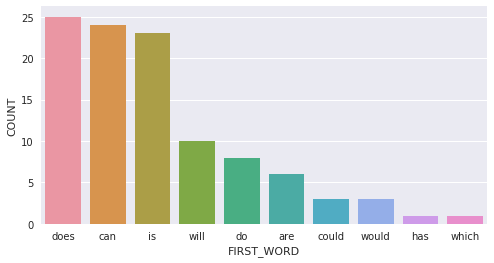

In [22]:
f, ax = plt.subplots(figsize=(8, 4))
ax = sns.barplot(x="FIRST_WORD", y="COUNT", data=first_word_df)

In [23]:
##since the count of words 'which' and 'has' is very less..we need to check whether they are
##correct observations or not

In [24]:
first_word_pos = affirmation_data.groupby(
    ['FIRST_WORD_POS','FIRST_WORD']).size().reset_index().rename(columns={
        0: 'COUNT'
    }).sort_values(
        'COUNT', ascending=False)

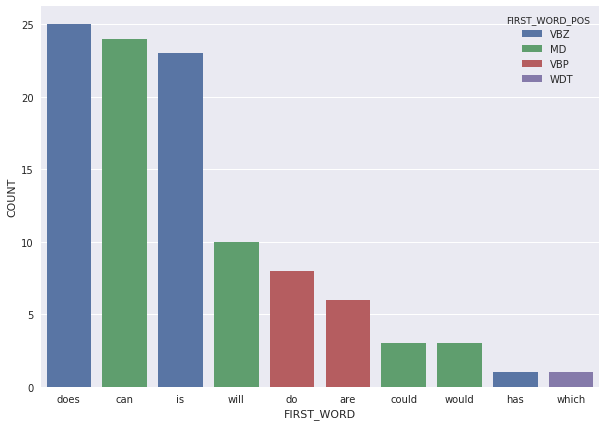

In [25]:
f, ax = plt.subplots(figsize=(10, 7))
sns.barplot(
    x="FIRST_WORD",y='COUNT',hue="FIRST_WORD_POS", data=first_word_pos,dodge=False)

VBZ,MD and VBP are in good quantity but 'has' and 'which' are very less..also there is no way 'which' can come in affirmation question.This seems to be an outlier so we can remove 'which' observation from our data

In [26]:
affirmation_data = affirmation_data[~(affirmation_data['FIRST_WORD_POS']=='WDT')]

In [27]:
len(affirmation_data)

103

### 'Who' Data

In [28]:
who_data = training_data[(training_data['LABEL']=='who')]

In [29]:
who_data.head()

,FIRST_WORD,FIRST_WORD_POS,FIRST_NBOR_POS,ROOT_TAG,LABEL
12,who,WP,VBD,VBD,who
13,who,WP,VBD,VBD,who
26,who,WP,VBD,VBD,who
52,who,WP,VBD,VBD,who
54,who,WP,VBZ,VBZ,who


In [30]:
first_word_pos = who_data.groupby(
    ['FIRST_WORD_POS','FIRST_WORD']).size().reset_index().rename(columns={
        0: 'COUNT'
    }).sort_values(
        'COUNT', ascending=False)

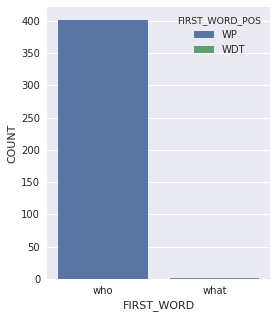

In [31]:
f, ax = plt.subplots(figsize=(4, 5))
sns.barplot(
    x="FIRST_WORD",y='COUNT',hue="FIRST_WORD_POS", data=first_word_pos,dodge=False)

In [32]:
## count of 'what' is very less..have to check this observation

In [33]:
who_data[who_data['FIRST_WORD_POS']=='WDT']

,FIRST_WORD,FIRST_WORD_POS,FIRST_NBOR_POS,ROOT_TAG,LABEL
1158,what,WDT,NN,VBD,who


In [34]:
#'what' is tagged as WH-Determiner because it not acting as the head of a wh- noun phrase,so this
#observation is correct and is importance feature for our classifier

### 'What' Data

In [35]:
what_data = training_data[(training_data['LABEL']=='what')]

In [36]:
what_data.head()

,FIRST_WORD,FIRST_WORD_POS,FIRST_NBOR_POS,ROOT_TAG,LABEL
1,what,WP,NNS,VBD,what
3,what,WDT,NN,VBZ,what
4,what,WP,VBZ,VBZ,what
5,what,WP,JJ,VBD,what
6,what,WDT,NN,VBD,what


In [37]:
first_word_pos = what_data.groupby(
    ['FIRST_WORD_POS','FIRST_WORD']).size().reset_index().rename(columns={
        0: 'COUNT'
    }).sort_values(
        'COUNT', ascending=False)

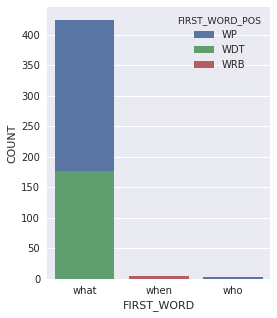

In [38]:
f, ax = plt.subplots(figsize=(4, 5))
sns.barplot(
    x="FIRST_WORD",y='COUNT',hue="FIRST_WORD_POS", data=first_word_pos,dodge=False)

In [39]:
##since count of 'when' and 'who' is less.need to check

In [40]:
what_data[what_data['FIRST_WORD'].isin(['when','who'])]

,FIRST_WORD,FIRST_WORD_POS,FIRST_NBOR_POS,ROOT_TAG,LABEL
98,when,WRB,VBD,VBD,what
277,when,WRB,VBZ,VBG,what
482,when,WRB,VBZ,VBZ,what
503,who,WP,VBD,VBD,what
575,who,WP,VBD,VBD,what
647,who,WP,VBD,VBD,what
783,when,WRB,VBD,VBD,what
787,when,WRB,VBD,VBD,what


In [41]:
##second and third observation whose 'firt nbor pos' is VBZ,seems wrongly labelled because 'when'
# first word pos 'WRB' and first nbor pos 'VBZ' mostly comes when output label is 'when'

#these two are outliers..so can be removed

In [42]:
what_data = what_data[~((what_data['FIRST_WORD']=='when')&(what_data['FIRST_NBOR_POS']=='VBZ'))]

In [43]:
len(what_data)

607

### 'When' Data

In [44]:
when_data = training_data[(training_data['LABEL']=='when')]

In [45]:
when_data.head()

,FIRST_WORD,FIRST_WORD_POS,FIRST_NBOR_POS,ROOT_TAG,LABEL
10,when,WRB,VBD,VBN,when
36,when,WRB,VBD,VB,when
90,when,WRB,VBD,VB,when
203,when,WRB,VBD,VBD,when
228,when,WRB,VBD,VB,when


In [46]:
first_word_pos = when_data.groupby(
    ['FIRST_WORD_POS','FIRST_WORD']).size().reset_index().rename(columns={
        0: 'COUNT'
    }).sort_values(
        'COUNT', ascending=False)

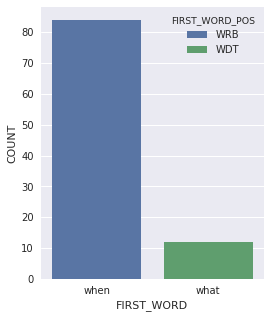

In [47]:
f, ax = plt.subplots(figsize=(4, 5))
sns.barplot(
    x="FIRST_WORD",y='COUNT',hue="FIRST_WORD_POS", data=first_word_pos,dodge=False)

In [48]:
#since first word'when' is always WRB..lets check neighbour word POS

In [49]:
nbor_word_pos = when_data[when_data['FIRST_WORD']=='when'].groupby(
    ['FIRST_WORD_POS','FIRST_NBOR_POS']).size().reset_index().rename(columns={
        0: 'COUNT'
    }).sort_values(
        'COUNT', ascending=False)

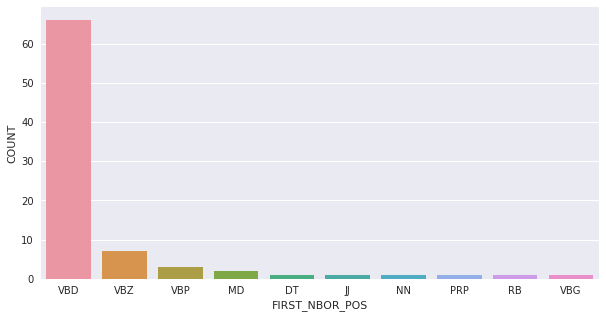

In [50]:
f, ax = plt.subplots(figsize=(10, 5))
sns.barplot(
    x="FIRST_NBOR_POS",y='COUNT', data=nbor_word_pos,dodge=False)

In [51]:
##lets check count is 1

In [52]:
nbor_word_pos[nbor_word_pos['COUNT']==1]

,FIRST_WORD_POS,FIRST_NBOR_POS,COUNT
0,WRB,DT,1
1,WRB,JJ,1
3,WRB,NN,1
4,WRB,PRP,1
5,WRB,RB,1
7,WRB,VBG,1


In [53]:
when_data[(when_data['FIRST_WORD'].isin(['when']))
          & (when_data['FIRST_NBOR_POS'].isin(['DT', 'JJ','NN','PRP','RB','VBG']))]

,FIRST_WORD,FIRST_WORD_POS,FIRST_NBOR_POS,ROOT_TAG,LABEL
589,when,WRB,VBG,NN,when
1223,when,WRB,DT,VBD,when
1225,when,WRB,JJ,VBD,when
1228,when,WRB,PRP,VBZ,when
1247,when,WRB,NN,VBZ,when
1263,when,WRB,RB,VB,when


In [54]:
##for any question WH-adverb cannot come with determiner,proper noun,noun,adverb.so these are all wrong 
#observations or outliers and can be removed from our dataset

In [55]:
when_data = when_data[~((when_data['FIRST_WORD'].isin(['when']))
          & (when_data['FIRST_NBOR_POS'].isin(['DT', 'JJ','NN','PRP','RB','VBG'])))]

### 'unknown' data

In [56]:
unknown_data = training_data[(training_data['LABEL']=='unknown')]

In [57]:
unknown_data.head()

,FIRST_WORD,FIRST_WORD_POS,FIRST_NBOR_POS,ROOT_TAG,LABEL
0,how,WRB,VBD,VB,unknown
2,how,WRB,MD,VB,unknown
9,name,VB,DT,VB,unknown
11,why,WRB,VBP,RB,unknown
17,how,WRB,JJ,VBN,unknown


In [58]:
first_word_df = unknown_data.groupby(
    'FIRST_WORD').size().reset_index().rename(columns={
        0: 'COUNT'
    }).sort_values(
        'COUNT', ascending=False)

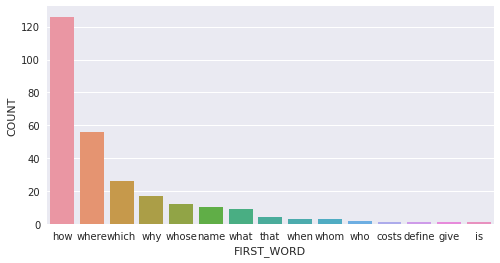

In [59]:
f, ax = plt.subplots(figsize=(8, 4))
ax = sns.barplot(x="FIRST_WORD", y="COUNT", data=first_word_df)

In [60]:
#as we can see first word 'what','who','when','is' is also coming..so these are also outliers
#for this set of data..we can remove these as well

In [61]:
unknown_data = unknown_data[~unknown_data['FIRST_WORD'].isin(['what','who','when','is'])]

In [62]:
len(affirmation_data),len(what_data),len(when_data),len(who_data),len(unknown_data)

(103, 607, 90, 402, 257)

In [63]:
len(affirmation_data)+len(what_data)+len(when_data)+len(who_data)+len(unknown_data)

1459

In [64]:
len(training_data)

1483

Merging all dataframes

In [65]:
training_data = affirmation_data.append(what_data,ignore_index=True)
training_data = training_data.append(when_data,ignore_index=True)
training_data = training_data.append(who_data,ignore_index=True)
training_data = training_data.append(unknown_data,ignore_index=True)

In [66]:
#our model should not break when some other feature class comes while testing..so to avoid that
#we are training our model with 'OTHERS' category and assign it to 'unknown' category

In [67]:
training_data.loc[len(training_data)]=['OTHERS']*4+['unknown']

Label encoding and one hot encoding

In [68]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

In [69]:
def label_func(label):
    return label_dict[label]

In [70]:
training_data['LABEL'] = training_data['LABEL'].apply(label_func)

In [71]:
Y = training_data['LABEL'].values

In [72]:
X = training_data[['FIRST_WORD','FIRST_WORD_POS','FIRST_NBOR_POS','ROOT_TAG']].values

In [73]:
X = X.astype('str')

In [74]:
labelencoder_dict = {}
onehotencoder_dict = {}
X_train = None
for i in range(0, X.shape[1]):
    label_encoder = LabelEncoder()
    labelencoder_dict[i] = label_encoder
    feature = label_encoder.fit_transform(X[:,i])
    feature = feature.reshape(X.shape[0], 1)
    onehot_encoder = OneHotEncoder(sparse=False)
    feature = onehot_encoder.fit_transform(feature)
    onehotencoder_dict[i] = onehot_encoder
    if X_train is None:
        X_train = feature
    else:
        X_train = np.concatenate((X_train, feature), axis=1)

In [75]:
with open('labelencoder_dict.pickle','wb') as fh:
    pickle.dump(labelencoder_dict,fh)

with open('onehotencoder_dict.pickle','wb') as fh:
    pickle.dump(onehotencoder_dict,fh)

In [76]:
X_train.shape

(1460, 72)

In [77]:
from sklearn.model_selection import train_test_split

In [78]:
X_train,X_eval,y_train,y_eval = train_test_split(X_train,Y,test_size=0.20,random_state =41)

## Model Training 

In [79]:
##Using decision tree classifier
from sklearn import tree

In [80]:
model = tree.DecisionTreeClassifier()

In [81]:
model.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [82]:
with open('model.pickle','wb') as fh:
    pickle.dump(model,fh)

In [83]:
y_pred = model.predict(X_eval)

In [84]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support as score

In [85]:
model.score(X_eval,y_eval)

0.9965753424657534

In [86]:
confusion_matrix(y_eval, y_pred)

array([[ 85,   0,   0,   0,   0],
       [  0, 115,   1,   0,   0],
       [  0,   0,  20,   0,   0],
       [  0,   0,   0,  18,   0],
       [  0,   0,   0,   0,  53]])

In [87]:
precision, recall, fscore, support = score(y_eval, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

precision: [1.         1.         0.95238095 1.         1.        ]
recall: [1.         0.99137931 1.         1.         1.        ]
fscore: [1.         0.995671   0.97560976 1.         1.        ]


In [88]:
#fscore for all classes seems good enough

## Model Testing

In [89]:
## Reading Testing data,model trained and encoders

In [90]:
test_data = pd.read_pickle('testing_data.pickle')
model = pd.read_pickle('model.pickle')
labelencoder_dict = pd.read_pickle('labelencoder_dict.pickle')
onehotencoder_dict = pd.read_pickle('onehotencoder_dict.pickle')

In [91]:
##to ensure that whatever data is coming for testing should bypass our code
##if any feature class is not found then it will be replace by below logic

In [92]:
missing_columns_lookup = {}

In [93]:
missing_columns_lookup['FIRST_WORD'] = [
    'is', 'does', 'will', 'can', 'do', 'could', 'has', 'would', 'are', 'what',
    'when', 'who', 'how', 'name', 'why', 'which', 'where', 'define', 'give',
    'whose', 'that', 'whom', 'costs'
]

missing_columns_lookup['FIRST_WORD_POS'] = [
    'VBZ', 'MD', 'VBP', 'WP', 'WDT', 'WRB', 'VB', 'NN', 'WP$'
]

missing_columns_lookup['FIRST_NBOR_POS'] = [
    'EX', 'PRP', 'DT', 'JJR', 'NN', 'VB', 'NNS', 'VBZ', 'JJ', 'VBP', 'VBG',
    'VBD', 'NNP', 'CD', '.', '``', 'RB', 'MD', 'IN'
]

missing_columns_lookup['ROOT_TAG'] = ['VBZ', 'VBG', 'VB', 'NN', 'VBN', 'VBP', 'JJ', 'VBD', 'NNS', 'IN',
       'NNP', 'UH', 'RB', 'PRP', 'JJR', 'POS', '.']

In [94]:
def validate_param(value1,value2,value3,value4):
    params = []
    if value1 not in missing_columns_lookup['FIRST_WORD']:
        params.append('OTHERS')
    else:
        params.append(value1)
    if value2 not in missing_columns_lookup['FIRST_WORD_POS']:
        params.append('OTHERS')
    else:
        params.append(value2)
    if value3 not in missing_columns_lookup['FIRST_NBOR_POS']:
        params.append('OTHERS')
    else:
        params.append(value3)
    if value4 not in missing_columns_lookup['ROOT_TAG']:
        params.append('OTHERS')
    else:
        params.append(value4)
    return params

In [95]:
data = []
for index, row in test_data.iterrows():
    data.append(validate_param(row[0], row[1], row[2], row[3]))

In [96]:
test_data = pd.DataFrame(data=data,columns=feature_columns)

In [97]:
X = test_data.values

In [98]:
X = X.astype('str')

In [99]:
def getEncoded(test_data,labelencoder_dict,onehotencoder_dict):
    test_encoded_x = None
    for i in range(0,test_data.shape[1]):
        label_encoder =  labelencoder_dict[i]
        feature = label_encoder.transform(test_data[:,i])
        feature = feature.reshape(test_data.shape[0], 1)
        onehot_encoder = onehotencoder_dict[i]
        feature = onehot_encoder.transform(feature)
        if test_encoded_x is None:
            test_encoded_x = feature
        else:
            test_encoded_x = np.concatenate((test_encoded_x, feature), axis=1)
    return test_encoded_x

In [100]:
X_test = getEncoded(X,labelencoder_dict,onehotencoder_dict)

In [101]:
X_test.shape

(1000, 72)

In [102]:
y_predict = model.predict(X_test)

In [103]:
##Reading Parsed sentences data
test_data = pd.read_pickle('parsed_sentences.pickle')

In [104]:
test_data['LABEL'] = y_predict

In [105]:
test_data['LABEL'] = test_data['LABEL'].apply(label_func)

In [106]:
test_data

,SENTENCES,LABEL
0,How did serfdom develop in and then leave Russ...,unknown
1,What films featured the character Popeye Doyle ?,what
2,How can I find a list of celebrities ' real na...,unknown
3,What fowl grabs the spotlight after the Chines...,what
4,What is the full form of .com ?,what
5,What contemptible scoundrel stole the cork fro...,what
6,What team did baseball 's St. Louis Browns bec...,what
7,What is the oldest profession ?,what
8,What are liver enzymes ?,what
9,Name the scar-faced bounty hunter of The Old W...,unknown
